# Evaluation

## Load packages and define base directory

In [1]:
from pathlib import Path
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# Define base_dir for consistent path management
notebook_dir = Path(os.getcwd()).resolve()
base_dir = notebook_dir.parent
print(base_dir)

/home/cgoehler/team-extra/ndvi-time-series-prediction


## Analysing prediction results and comparing models

As mentioned in the Data Preprocessing chapter (Challenges in Modelling) the criterion for selection of cubes was the completeness of the time series. The four cubes with the fewest measurement and time gaps were chosen (I: Cube 665, II: Cube 80, III: Cube 1203, IV: Cube 1301).
For comparison we plot the NDVI time series original data with the prediction results of the different models for one example pixel per cube. The example pixel is chosen by the minimum test MSE of the SARIMA model for each cube, as this model seems to capture the course of the NDVI time series the best. The MSE is calculated with: 

$MSE = \frac{1}{n} \sum_{i=1}^{n}(Y_i - \bar Y_i)^2$

With
- $Y_i$ ... observed value
- $\bar Y_i$ ... predicted value

In [16]:
# Function to load data from NetCDF file and defining variables
def load_nc_file(file_path, ndvi_var_name, x_dim_name, y_dim_name, mse_name=""):
    """
    Load data from a NetCDF file and define variables for NDVI, time, and spatial dimensions.
    
    Parameters:
    file_path (str or Path): The path to the NetCDF file.
    ndvi_var_name (str): The variable name for NDVI data in the NetCDF file.
    x_dim_name (str): The name of the x dimension (e.g., latitude) in the NetCDF file.
    y_dim_name (str): The name of the y dimension (e.g., longitude) in the NetCDF file.
    mse_name (str, optional): The variable name for mean squared error (MSE) data in the NetCDF file. Default is an empty string.

    Returns:
    tuple: A tuple containing the NDVI data, time data, x dimension data, y dimension data, and optionally MSE data.
    """
    ds = xr.open_dataset(file_path)
    try:
        ndvi = ds[ndvi_var_name]
        times = ds['time']
        x = ds[x_dim_name] # lat for lstm
        y = ds[y_dim_name] # lon for lstm
        mse = ds[mse_name]
        return ndvi, times, x, y, mse
    except:
        ndvi = ds[ndvi_var_name]
        times = ds['time']
        x = ds[x_dim_name] # lat for lstm
        y = ds[y_dim_name] # lon for lstm
        return ndvi, times, x, y

In [5]:
# Function to determine the pixel with the lowest test mse (SARIMA) in each cube
def find_min_test_mse(datasets, cube_names):
    """
    Find and print the pixel with the lowest test MSE in each dataset.
    
    Parameters:
    datasets (list of str): List of paths to the NetCDF datasets.
    cube_names (list of str): List of names for each cube corresponding to the datasets.
    """
    for i, dataset_path in enumerate(datasets):
        pred = xr.open_dataset(dataset_path)
        test_mse_values = pred['test_mse'].values
        min_test_mse_value = np.nanmin(test_mse_values)
        min_test_mse_index = np.unravel_index(np.nanargmin(test_mse_values), test_mse_values.shape)
        min_test_mse_coords = (pred['x'][min_test_mse_index[0]].item(), pred['y'][min_test_mse_index[1]].item())

        print(f"The minimum test MSE for {cube_names[i]} is: {min_test_mse_value} for pixel ({min_test_mse_coords})")

# Paths to the datasets
datasets = [
    base_dir / "data" / "data_predictions" / f'SARIMA_predicted_ds_B_Cube_{cube}_train.nc'
    for cube in [665, 80, 1203, 1301]
]

# Names of the cubes
cube_names = [
    'Cube 665',
    'Cube 80',
    'Cube 1203',
    'Cube 1301'
]

# Call the function
find_min_test_mse(datasets, cube_names)

The minimum test MSE for Cube 665 is: 0.0006814400117864885 for pixel ((93, 32))
The minimum test MSE for Cube 80 is: 0.003545171194203701 for pixel ((46, 84))
The minimum test MSE for Cube 1203 is: 0.0006025049006614665 for pixel ((49, 42))
The minimum test MSE for Cube 1301 is: 0.0058360315822941905 for pixel ((122, 106))


Cube 665 
Pixel x = 93, y = 32


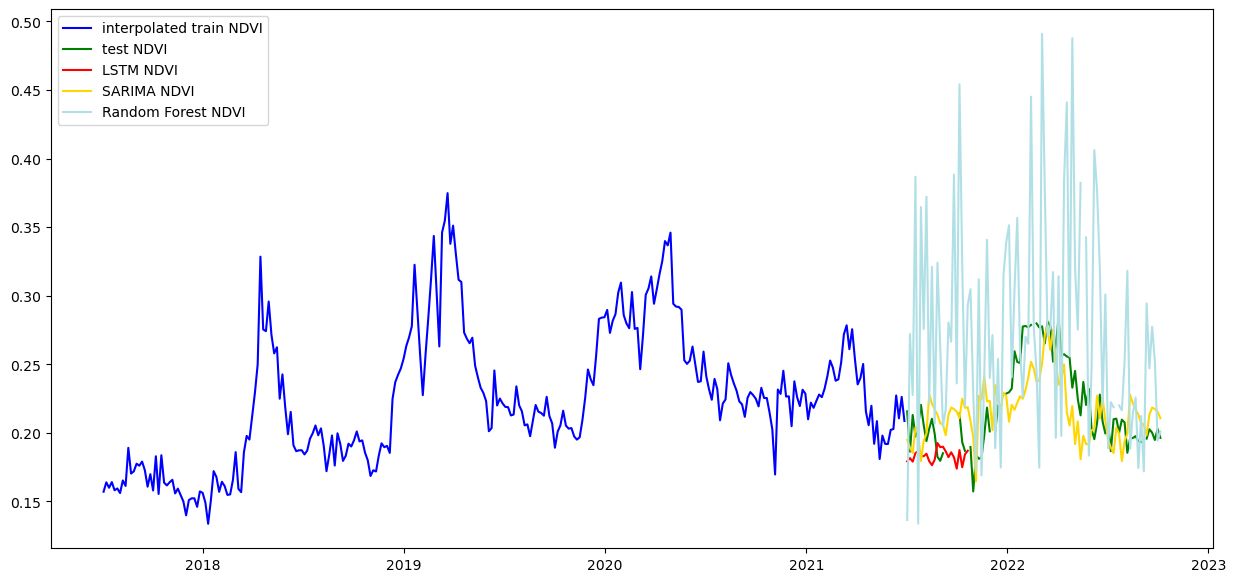

Cube 80 
Pixel x = 46, y = 84


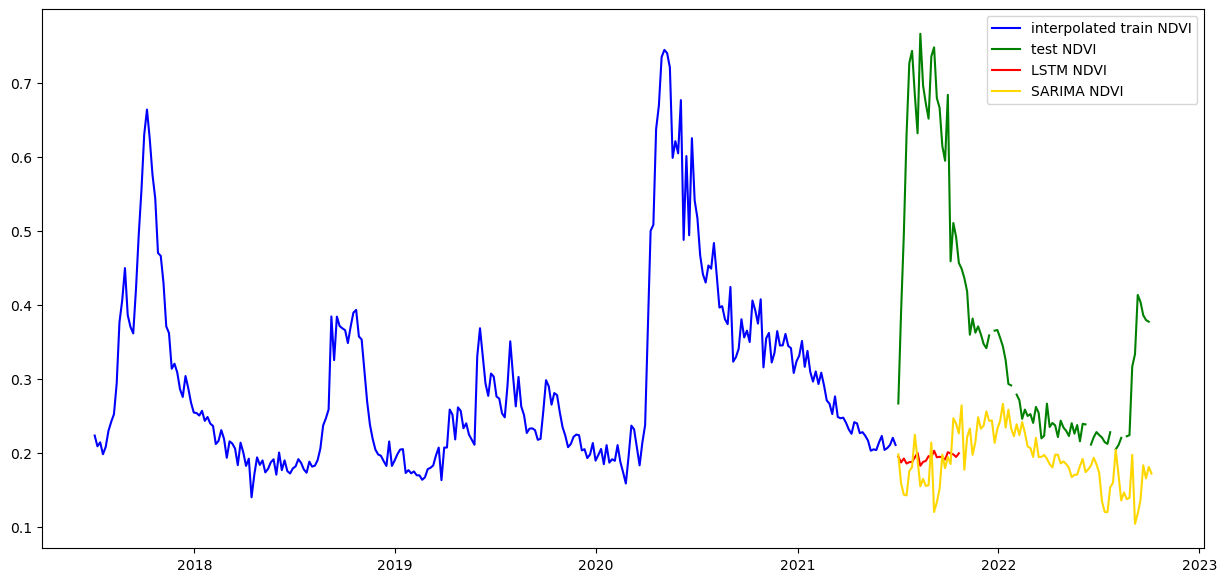

Cube 1203 
Pixel x = 49, y = 42


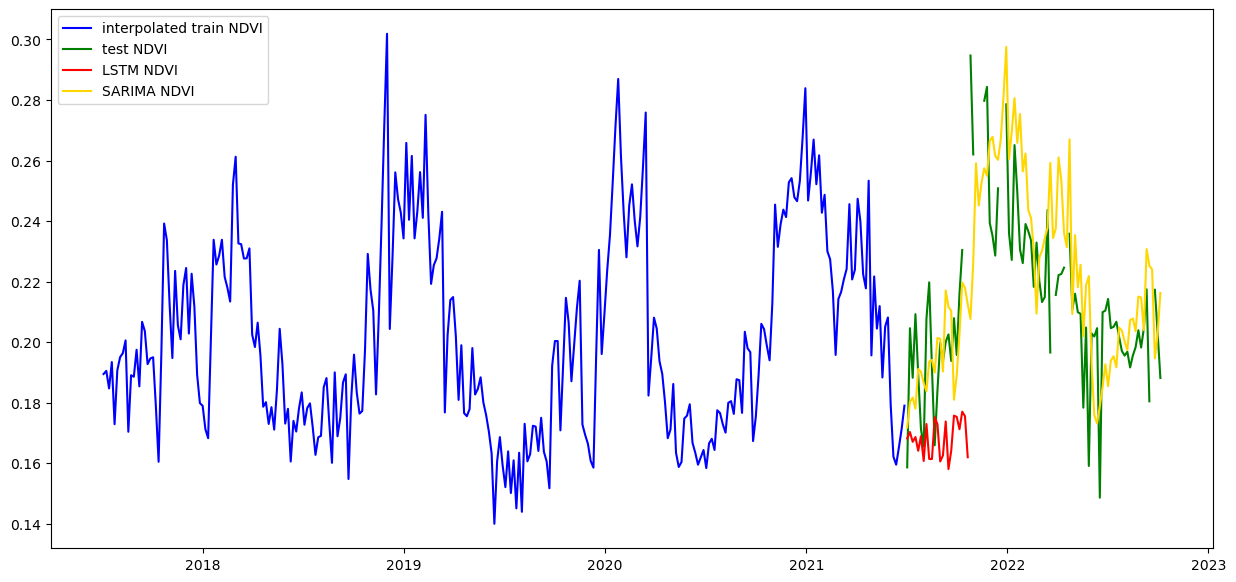

Cube 1301 
Pixel x = 122, y = 106


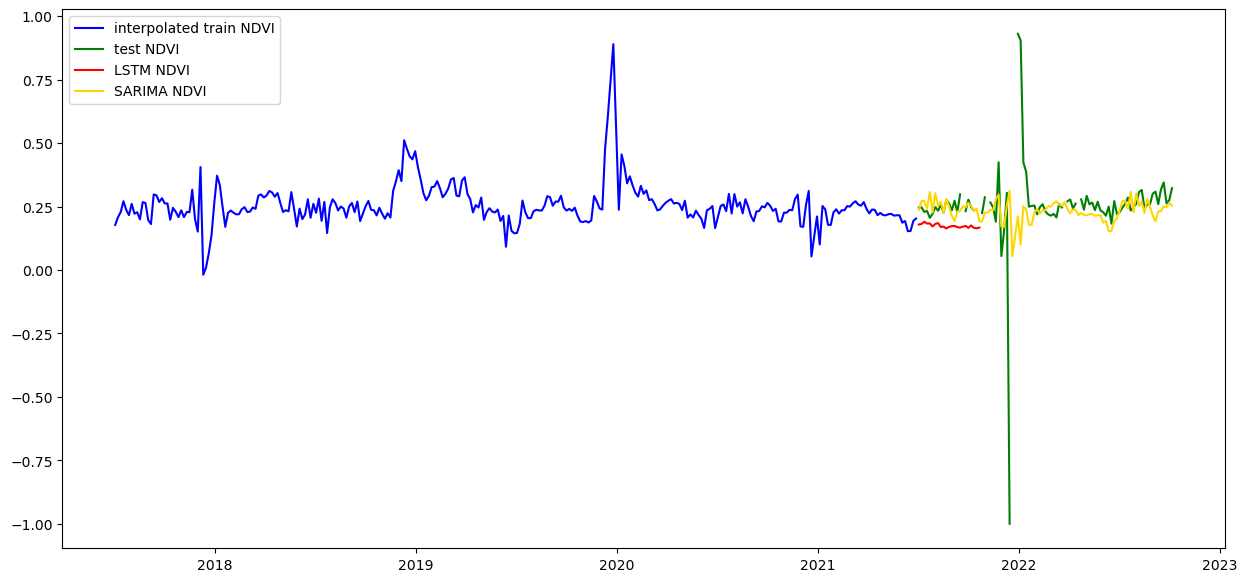

In [57]:
# Plot the NDVI time series for each cube and model
# Cubes considered
cubes = [665, 80, 1203, 1301]
# Pixel with best MSE for SARIMA for each cube
best_xy = [[93, 32], [46, 84], [49, 42], [122, 106]]

for i, cube in enumerate(cubes):
    # Directory to each cube
    directory = base_dir / "data"

    # File names of training and testing data as well as predictions by LSTM and SARIMA model
    train_nc = directory / f'data_train/ds_B_Cube_{cube}_train.nc'
    test_nc = directory / f'data_test/Cube_{cube}_test.nc'
    lstm_nc = directory / f'data_predictions/LSTM_predicted_Cube_{cube}_test.nc'
    sarima_nc = directory / f'data_predictions/SARIMA_predicted_ds_B_Cube_{cube}_train.nc'
    if cube == 665:
        rf_nc = directory / 'data_predictions/Random_Forest_Cube_665.nc'
        rf_ndvi, rf_times, rf_x, rf_y, rf_mse = load_nc_file(rf_nc, 'pred_ndvi', 'x', 'y', 'mse')
        rf_ndvi.where(rf_ndvi==0.0)

    # Import datasets and define variables
    train_ndvi, train_times, train_x, train_y = load_nc_file(train_nc, 'NDVI', 'x', 'y')
    test_ndvi, test_times, test_x, test_y = load_nc_file(test_nc, 'NDVI', 'x', 'y')
    lstm_ndvi, lstm_times, lstm_x, lstm_y, lstm_mse = load_nc_file(lstm_nc, 'NDVI', 'x', 'y', 'MSE')
    sarima_ndvi, sarima_times, sarima_x, sarima_y, sarima_mse = load_nc_file(sarima_nc, 'predictions', 'x', 'y', 'test_mse')

    x = best_xy[i][0]
    y = best_xy[i][1]

    # Plot time series of training, testing, and model data
    fig, ax = plt.subplots(1, 1, figsize=(15, 7))

    plt.plot(train_times, train_ndvi[:, x, y], label='interpolated train NDVI', color='blue')
    plt.plot(test_times, test_ndvi[:, x, y], label='test NDVI', color='green')
    plt.plot(lstm_times, lstm_ndvi[:, x, y], label='LSTM NDVI', color='red')
    plt.plot(sarima_times, sarima_ndvi[x, y, :], label='SARIMA NDVI', color='gold')
    
    if cube == 665:
        rf_ndvi[:, x, y][np.where(rf_ndvi[:, x, y] == 0.)] = np.nan
        plt.plot(test_times, rf_ndvi[:, x, y], label='Random Forest NDVI', color='powderblue')

        
    print(f'Cube {cube} \nPixel x = {x}, y = {y}')
    
    plt.legend()
    plt.show()

### Description of model performance based on example pixels plot (visual comparison)
The prediction results for each model visually differ a lot. 

The **SARIMA** model predictions follow the seasonality of the test data for the example pixels of cube 665 and 1203. For the example pixel of cube 80 the SARIMA model predictions fail in predicting the NDVI amplitude in the last months of 2021, but in general are able to follow the seasonality of the data. 
The SARIMA model predictions follow the NDVI time series for the prediction steps in the example pixel of cube 1301 besides the test data artifact around the turn of the year from 2021 to 2022.

The **Random Forest** NDVI predictions in cube 665 show strong fluctuations and higher deviations from the test NDVI data then the other models. Due to processing time it was not able to run a Random Forest model for the other three cubes. 

The **LSTM** model only predicted a short term period (23 time steps) for the NDVI time series (see chapter 2.2 LSTM). For the example pixels in cube 665 and 1301 the LSTM model predictions follow the course of the test data for the first 23 time steps. For the example pixels of cube 80 and 1203 the LSTM model fails in predicting reliable NDVI values that follow the seasonality and trend of the test data. 

From visual comparison we can conclude that the SARIMA models capture best the seasonality and trend of the NDVI time series for the 93 prediction steps, LSTM is able to predict a short term period that partly follows the seasonality, while Random Forest shows more variability in its predictions.

## Test Mean Squared Error (MSE) comparison for each cube and example pixel
For model evaluation we choose the test Mean Squared Error (MSE), calculated as the difference between the test and predicted data. 
The MSE is a widely recognized metric for evaluating the performance of predictive models [@Arumugam2023]. 
We compare the mean test MSE over all pixels of a cube and the pixel wise test MSE of each example pixel of each cube in bar plots for all models.

In [14]:
# Calculate and print the pixel wise and cube wise mean squared error for each model
# Lists to store MSE values
lstm_cube_mse_list = []
sarima_cube_mse_list = []
lstm_pixel_mse_list = []
sarima_pixel_mse_list = []

for i, cube in enumerate(cubes):
    # Directory to each cube
    directory = base_dir / "data"

    # File names of training and testing data as well as predictions by LSTM and SARIMA model
    train_nc = directory / f'data_train/ds_B_Cube_{cube}_train.nc'
    test_nc = directory / f'data_test/Cube_{cube}_test.nc'
    lstm_nc = directory / f'data_predictions/LSTM_predicted_Cube_{cube}_test.nc'
    sarima_nc = directory / f'data_predictions/SARIMA_predicted_ds_B_Cube_{cube}_train.nc'
    if cube == 665:
        rf_nc = directory / 'data_predictions/Random_Forest_Cube_665.nc'
        rf_ndvi, rf_times, rf_x, rf_y, rf_mse = load_nc_file(rf_nc, 'pred_ndvi', 'x', 'y', 'mse')
        rf_ndvi.where(rf_ndvi==0.0)

    # Import datasets and define variables
    train_ndvi, train_times, train_x, train_y = load_nc_file(train_nc, 'NDVI', 'x', 'y')
    test_ndvi, test_times, test_x, test_y = load_nc_file(test_nc, 'NDVI', 'x', 'y')
    lstm_ndvi, lstm_times, lstm_x, lstm_y, lstm_mse = load_nc_file(lstm_nc, 'NDVI', 'x', 'y', 'MSE')
    sarima_ndvi, sarima_times, sarima_x, sarima_y, sarima_mse = load_nc_file(sarima_nc, 'predictions', 'x', 'y', 'test_mse')

    x = best_xy[i][0]
    y = best_xy[i][1]

    # Calculate pixel MSE for LSTM
    mask = np.isfinite(test_ndvi[:, x, y])
    mask = mask[0:len(lstm_times)]
    lstm_pixel_mse = mean_squared_error(test_ndvi[:, x, y][0:len(lstm_times)][mask], lstm_ndvi[:, x, y][mask])

    print(f'Cube {cube} \nPixel x = {x}, y = {y}')
    print(f'Pixel MSE from SARIMA: {sarima_mse[x, y].values}')
    print(f'Cube MSE from SARIMA: {sarima_mse.mean().values}')
    print(f'Pixel MSE from LSTM: {lstm_pixel_mse}')
    print(f'Cube MSE from LSTM: {lstm_mse.values}')
    if cube == 665:
        print(f'Pixel MSE from Random Forest: {rf_mse[x, y].values}')
        print(f'Cube MSE from Random Forest: {rf_mse.mean().values}')

    # Append cube MSE
    lstm_cube_mse_list.append(lstm_mse)
    sarima_cube_mse_list.append(sarima_mse.mean().values)
    # Append pixel MSE
    lstm_pixel_mse_list.append(lstm_pixel_mse)
    sarima_pixel_mse_list.append(sarima_mse[x, y].values)

Cube 665 
Pixel x = 93, y = 32
Pixel MSE from SARIMA: 0.0006814400117864885
Cube MSE from SARIMA: 0.007087799911625777
Pixel MSE from LSTM: 0.0004515084729064256
Cube MSE from LSTM: 0.13620756566524506
Pixel MSE from Random Forest: 0.005258710123598576
Cube MSE from Random Forest: 0.01674204133450985
Cube 80 
Pixel x = 46, y = 84
Pixel MSE from SARIMA: 0.003545171194203701
Cube MSE from SARIMA: 0.05865153656459794
Pixel MSE from LSTM: 0.1886572241783142
Cube MSE from LSTM: 0.20980994403362274
Cube 1203 
Pixel x = 49, y = 42
Pixel MSE from SARIMA: 0.0006025049006614665
Cube MSE from SARIMA: 0.059179499826998834
Pixel MSE from LSTM: 0.0010537380585446954
Cube MSE from LSTM: 0.09221689403057098
Cube 1301 
Pixel x = 122, y = 106
Pixel MSE from SARIMA: 0.0058360315822941905
Cube MSE from SARIMA: 0.06264543209138485
Pixel MSE from LSTM: 0.005719645880162716
Cube MSE from LSTM: 0.2933070659637451


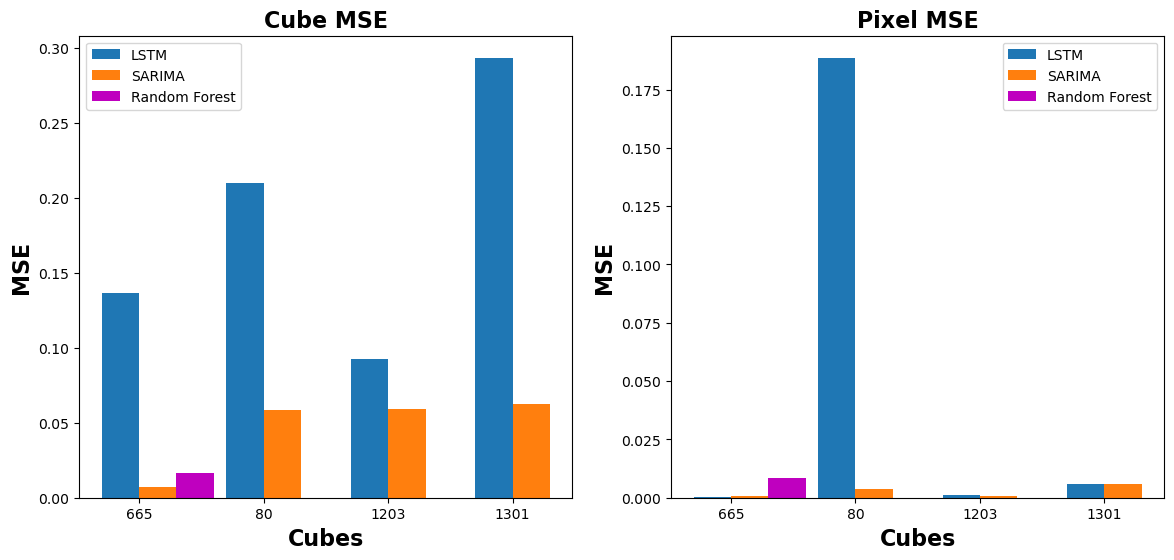

In [15]:
# Positions of the bars on the x-axis
bar_width = 0.3
indices = np.arange(len(cubes))
rf_index = 0

# Create the bar plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax1 = plt.subplot(121)
# Bar positions for each model
bar1 = ax1.bar(indices, lstm_cube_mse_list, bar_width, label='LSTM')
bar3 = ax1.bar(indices + bar_width, sarima_cube_mse_list, bar_width, label='SARIMA')
# Adding the single MSE value as an additional bar
ax1.bar(rf_index + 2 * bar_width, rf_mse.mean().values, bar_width, label='Random Forest', color='m')

# Adding labels, title, and legend
ax1.set_xlabel('Cubes',
              fontsize=16,
              fontweight='semibold')
ax1.set_ylabel('MSE',
              fontsize=16,
              fontweight='semibold')
ax1.set_xticks(indices + bar_width /2)
ax1.set_xticklabels(cubes)
ax1.set_title('Cube MSE',
              fontsize=16,
              fontweight='semibold')
ax1.legend()

ax2 = plt.subplot(122)

# Bar positions for each model
bar2 = ax2.bar(indices, lstm_pixel_mse_list, bar_width, label='LSTM')
bar4 = ax2.bar(indices + bar_width, sarima_pixel_mse_list, bar_width, label='SARIMA')
# Adding the single MSE value as an additional bar
ax2.bar(rf_index + 2 * bar_width, rf_mse[x,y].values, bar_width, label='Random Forest', color='m')

# Adding labels, title, and legend
ax2.set_xlabel('Cubes',
              fontsize=16,
              fontweight='semibold')
ax2.set_ylabel('MSE',
              fontsize=16,
              fontweight='semibold')
ax2.set_xticks(indices + bar_width / 2)
ax2.set_xticklabels(cubes)
ax2.set_title('Pixel MSE',
              fontsize=16,
              fontweight='semibold')
ax2.legend()

# Display the plot
plt.show()

### Description of model performance based on mean test MSE per cube and pixel wise test MSE per example pixel (analytic comparison)

The cube wise mean test MSE of the LSTM model is higher for all cubes than the mean test MSE of the SARIMA and Random Forest model. That means that the SARIMA and Random Forest model performed better in predictions than the LSTM model. 

**SARIMA** performed best in predicting the NDVI time series of cube 665 with a mean test MSE of ~0.0071 for the cube. The mean test MSE for cubes 80, 1203 and 1301 is varying around ~0.06 (with ~0.0587, ~0.0592 and ~0.0627 respectively). 

**Random Forest** shows a moderate performance for the mean test MSE in cube 665 with ~0.0167. 

**LSTM** performed best in predicting the NDVI time series of cube 1203 with a test MST of ~0.0922. The test MSE for cubes 665, 80 and 1301 is varying between 0.1362 and 0.2933 (with ~0.1362, ~0.2098 and ~0.2933 respectively). 

The best performing model differs for each example pixel considering the pixel wise test MSE. For all but cube 80 the pixel wise test MSE is smaller than ~0.006 for all models. 

**SARIMA** shows the smallest test MSE of all models for the example pixels in cube 80 and 1203 with ~0.0036 and ~0.0006 respectively. For the example pixels in cube 665 and 1301 SARIMAs test MSE is varying between ~ 0.0007 and ~0.0058 respectively. 

**Random Forest** shows the highest test MSE of all models for the example pixel in cube 665 with ~0.0053. 

**LSTM** shows the smallest test MSE of all models for the example pixels in cube 665 and 1301 with ~0.0005 and ~0.0057 respectively. For the example pixels in cube 80 and 1203 LSTM test MSE is varying between ~0.1887 and ~0.0011 respectively. It is conspicuous that the pixel wise test MSE of the LSRM model is very high for the example pixel in cube 80, while its mean test MSE for the total cube is only the third highest of all cubes for the LSTM. 

From the analytical comparison we can conclude that the SARIMA model consistently has lower Cube MSEs, indicating better performance across entire datasets, offering more reliable and consistent predictions. While the LSTM model sometimes has the lowest Pixel MSE but often shows higher Cube MSEs, suggesting potential overfitting to specific pixels and variability in its performance depending on the specific characteristics of each cube. The Random Forest model only evaluated the test MSE for Cube 665, where it showed moderate performance with higher variability.

## Challenges in comparison of model performance

For the comparison we are facing some challenges: 

- Incomplete Predictions: The LSTM model only provides predictions for 23 out of 93 time steps, making it difficult to assess its performance over the entire testing period. This limited prediction window complicates direct comparison with the SARIMA and Random Forest model (the latter only for cube 665) that have predictions for all time steps. The test MSE calculation for the incomplete prediction period of the LSTM model is based on fewer data points. This can lead to an underestimation or overestimation of the true error, depending on the characteristics of the predicted and unpredicted periods.
- Single Cube Prediction: The Random Forest model predicts values for only one of the four cubes. This limits the ability to generalize its performance across different datasets and environmental conditions represented by the other cubes.
- Different Cubes: Comparing models across different cubes can introduce variability due to inherent differences in the data. Some cubes might be more challenging to predict than others, leading to higher MSEs not necessarily indicative of the model's overall performance.
- Pixel vs. Cube MSE: There can be a significant difference between the pixel-wise and cube-wise MSEs. The pixel-wise MSE focuses on specific locations, which might exhibit unique patterns and variabilities, while the cube-wise MSE averages the errors over the entire dataset. This averaging can sometimes hide localized errors but provide a more generalized performance metric. As we selected the example pixels by the lowest pixel wise test MSE of the SARIMA model the results of the comparison of the pixel wise test MSE could differ if we change the selection process e.g. by selecting the pixels with the lowest test MSE of the LSTM model or taking into account several different example pixels for each cube. 

## Conclusion
In this analysis, we compared the performance of three different models — SARIMA, Random Forest and LSTM — for predicting NDVI (Normalized Difference Vegetation Index) from time series data across different minicubes. Our objective was to evaluate the effectiveness and accuracy of these models in forecasting NDVI values, which are critical for monitoring vegetation health and ecological changes.

Overall, the SARIMA model emerged as the most consistent and reliable model for NDVI predictions across all four cubes. It consistently achieved lower cube-wise MSEs compared to the LSTM and Random Forest models, indicating its robustness in handling NDVI time series data. The LSTM model showed promise with lower pixel-wise MSEs in some instances but struggled with higher cube-wise MSEs and incomplete predictions. As LSTM model provided NDVI predictions for 23 out of the 93 time steps, it is limited in the comprehensiveness of its evaluation.
The Random Forest model showed a promising and effective result for Cube 665 and could, with more processing time and power, be applied to the other cubes as well.

One of the significant challenges encountered during this analysis was the complex data preprocessing required to prepare the NDVI time series for modeling. Variations in data quality, missing values, and differing temporal resolutions necessitated extensive interpolation and decomposition techniques, which could introduce biases and inconsistencies. These preprocessing steps made it difficult to ensure a fair comparison among the models, as each model might react differently to the processed data. 

Future work could explore enhancing the LSTM model's coverage and integrating Random Forest predictions across more cubes to provide a more comprehensive comparison. Additionally, addressing the challenges in model performance evaluation through more standardized and consistent metrics will further refine the accuracy and applicability of NDVI forecasting models.